# GPyTroch Regression

__The idea of this notebook is to derive from our own implementation to the GPyTorch implementation.__

### Resources

GPyTorch Documentation: https://docs.gpytorch.ai/en/stable/  
Gaussian Processes for Machine Learning book: http://www.gaussianprocess.org/gpml

### Imports

In [1]:
import os, math
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
import gpytorch
from tqdm import tqdm

In [2]:
from pylab import rcParams
rcParams['figure.figsize'] = 15, 5

### Plot Functions

In [3]:
plt_y_min, plt_y_max = -1.5, 6.5
plt_x_min, plt_x_max = -10, 10

In [4]:
def plot_data(X,Y,x_grid,y_true):
    plt.scatter(X, Y, color='b')
    plt.errorbar(X, Y, yerr=noise_scale, fmt='o')
    plt.plot(x_grid, y_true, color='lightblue')
    plt.fill_between(x_grid, y_true - noise_scale / 2, y_true + noise_scale / 2, alpha=0.1, color='lightblue')
    plt.ylim(-1.5,6.5)

In [5]:
def GaussPDFscaled(y, m, s):
    return np.exp(-0.5 * (y - m.T) ** 2 / (s ** 2).T)

In [6]:
def plot_prediction(X,Y, x_grid, y_true, mpost, spost, stdpo):
    fig, ax = plt.subplots(2,1, gridspec_kw={'height_ratios': [3, 1]})
    yy = np.linspace(plt_y_min, plt_y_max, mpost.shape[0]).reshape([mpost.shape[0],1])
    Ppost = GaussPDFscaled(yy, mpost.numpy()[::-1], stdpo)
    ax[0].imshow(Ppost, extent=[plt_x_min, plt_x_max, plt_y_min, plt_y_max], aspect="auto", origin="lower", cmap="Greys", alpha=0.4)
    ax[0].scatter(X, Y, color='b')
    ax[0].errorbar(X, Y, yerr=noise_scale, fmt='o')
    ax[0].plot(x_grid, y_true, color='lightblue')
    ax[0].plot(x_grid, mpost + 2 * stdpo, "-", color="lightcoral")
    ax[0].plot(x_grid, mpost - 2 * stdpo, "-", color="lightcoral")
    ax[0].plot(x_grid, mpost + 2 * stdpo + 2 * noise_scale, "-", color="gold")
    ax[0].plot(x_grid, mpost - 2 * stdpo - 2 * noise_scale, "-", color="gold")
    ax[0].fill_between(x_grid, y_true - noise_scale / 2, y_true + noise_scale / 2, alpha=0.1, color='lightblue')
    ax[0].set_ylim(plt_y_min, plt_y_max)
    ax[0].plot(x_grid, mpost, color="r")
    for i in range(spost.shape[1]):
        ax[0].plot(x_grid, spost[:,i], "--", color="r", alpha=0.2)
    ax[1].plot(x_grid, stdpo, "-", color="k")
    return ax

### Generate Regression Data

In [7]:
def data_function(x, noise_scale=0):
    true_Y = -0.0005*np.power(x, 4) + -0.008*np.power(x, 3) + 0.03*np.power(x, 2) + 0.7 * np.power(x, 1) + 2
    return true_Y + np.random.normal(0, scale=noise_scale, size=true_Y.shape)

In [8]:
n = 500 # number of grip-points for plotting
data_points = 10
noise_scale = 0.4
plot_window = (plt_x_min, plt_x_max) # size of data/plot window
x_grid = np.linspace(-plot_window[0], plot_window[0], 100)
data_window = (plot_window[0] +1, plot_window[1] -1)

In [9]:
X = np.random.uniform(*data_window, size=data_points)
train_x = torch.FloatTensor(X)
train_y = torch.FloatTensor(data_function(X, noise_scale))
test_x = torch.FloatTensor(x_grid)
test_y = torch.FloatTensor(data_function(x_grid))

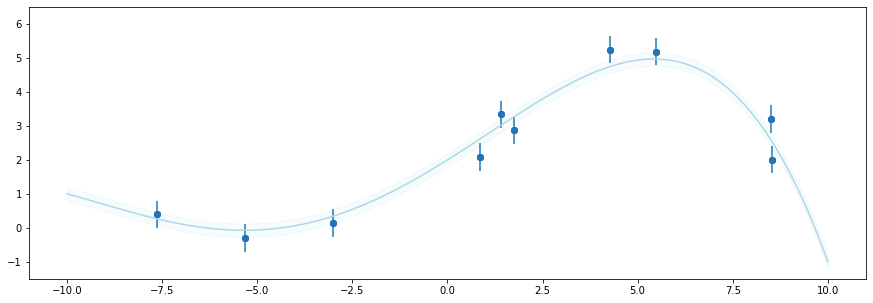

In [10]:
plot_data(train_x,train_y,test_x,test_y)

## Our GP in PyTorch

A mean function with a the mean constant as hyperparameter:

In [11]:
class MeanFunction(torch.nn.Module):
    
    def __init__(self,  mean_const: float=1.0) :
        super().__init__()
        self.mean_const = nn.Parameter(torch.tensor(
            mean_const, dtype=torch.float32, requires_grad=True
        ))
    
    def forward(self, x):
        return x * 0.0 + self.mean_const


The RBF kernal with the length-scale $l$ and $\sigma^2_f$, the variance of the (noise-free) signal.  


In [12]:
class RBF(torch.nn.Module):
    def __init__(self,  length_scale: float=1.0, sigma_f: float=1.0) :
        super().__init__()
        # initialize parameters
        self.length_scale = nn.Parameter(torch.tensor(
            length_scale, dtype=torch.float32, requires_grad=True
        ))
        self.sigma_f = nn.Parameter(torch.tensor(
            sigma_f, dtype=torch.float32, requires_grad=True
        ))

    def __call__(self, A, B):
        kernel_matrix = torch.zeros([A.shape[0], B.shape[0]])
        for j in range(A.shape[0]):
            for i in range(B.shape[0]):
                kernel_matrix[j,i] = self.sigma_f**2 * torch.exp(-1.0 * (A[j]-B[i]) ** 2 / (2.0 * self.length_scale ** 2) )
        if kernel_matrix.shape[0] == kernel_matrix.shape[1]:
            return kernel_matrix + 1e-5 * torch.eye(kernel_matrix.shape[0]) # numeric stabelized
        else:
            return kernel_matrix

In [13]:
kernel = RBF()
mean_function = MeanFunction()

In [14]:
mx = mean_function(test_x) 
mX = mean_function(train_x) 

kxx = kernel(test_x, test_x) 
kXX = kernel(train_x, train_x) 
kxX = kernel(test_x, train_x)

m_pre = kxX @ torch.linalg.inv(kXX + noise_scale ** 2 * torch.eye(data_points))
mpost = mx + m_pre @ (train_y - mX)
vpost = kxx - m_pre @ kxX.T 

dist = torch.distributions.multivariate_normal.MultivariateNormal(mpost, vpost)

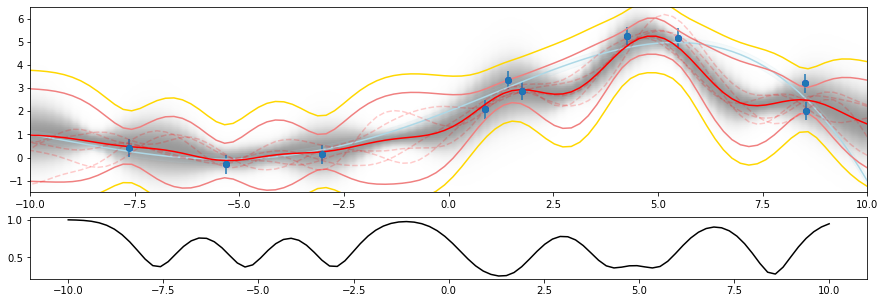

In [15]:
with torch.no_grad():
    mpost = dist.mean
    spost = dist.sample(torch.Size([5])).T
    stdpo = torch.sqrt(torch.diag(vpost))
    plot_prediction(train_x,train_y,test_x,test_y, mpost, spost, stdpo)

### Define Class Methods

#### Our Likelihood

In [16]:
class OurLikelihood(nn.Module):
    def __init__(self, noise_scale=0.0):
        super().__init__()
        self.noise_scale = nn.Parameter(torch.tensor(
            noise_scale, dtype=torch.float32, requires_grad=True
        ))
    
    def forward(self, f_x): 
        return torch.distributions.multivariate_normal.MultivariateNormal(f_x.mean, f_x.covariance_matrix + torch.eye(f_x.mean.shape[0]) * self.noise_scale ** 2)

In [17]:
likelihood = OurLikelihood(1.0)

In [18]:
class OurGPModel(nn.Module):
    def __init__(self, train_x, train_y, likelihood):
        super().__init__()
        self.mean = MeanFunction()
        self.kernel = RBF()
        self.likelihood = likelihood
        self.train_x = train_x
        self.train_y = train_y
    
    def forward(self, test_x):
        mx = self.mean(test_x) 
        kxx = self.kernel(test_x, test_x) 

        mX = self.mean(train_x) 
        kXX = self.kernel(self.train_x, self.train_x) 
        kxX = self.kernel(test_x, self.train_x)

        m_pre = kxX @ torch.linalg.inv(kXX + self.likelihood.noise_scale ** 2 * torch.eye(data_points)) 
        mpost = mx + m_pre @ (self.train_y - mX)
        mpost = m_pre @ self.train_y
        vpost = kxx - m_pre @ kxX.T + 1e-4 * torch.eye(kxx.shape[0]) # for numeric stability

        return torch.distributions.multivariate_normal.MultivariateNormal(mpost, vpost) 

In [19]:
model = OurGPModel(train_x, train_y, likelihood)

In [20]:
for name, param in model.named_parameters():
    print(f"model parameter name: {name:42} value: {param.data}   shape: {param.shape}")

model parameter name: mean.mean_const                            value: 1.0   shape: torch.Size([])
model parameter name: kernel.length_scale                        value: 1.0   shape: torch.Size([])
model parameter name: kernel.sigma_f                             value: 1.0   shape: torch.Size([])
model parameter name: likelihood.noise_scale                     value: 1.0   shape: torch.Size([])


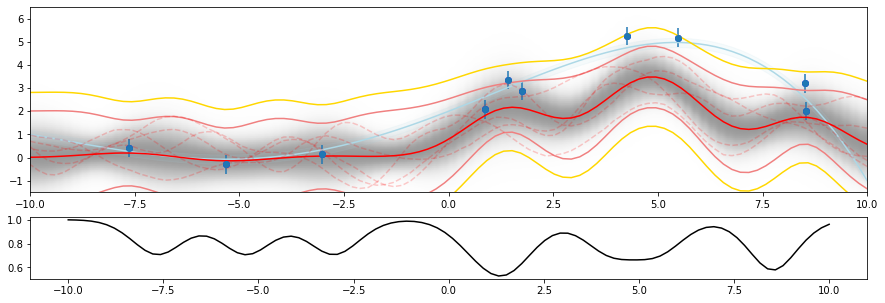

In [21]:
with torch.no_grad():  
    output_distribution = model(test_x)
    mpost = output_distribution.mean.unsqueeze(1)
    stdpo = output_distribution.variance.sqrt().unsqueeze(1)
spost = output_distribution.sample(sample_shape=torch.Size([5])).T
plot_prediction(train_x,train_y,test_x,test_y, mpost, spost, stdpo);

### Train our PyTorch GP

The marginal log-likelihood objective

\begin{equation*}
          \mathcal{L} = p_f(\mathbf y \! \mid \! \mathbf X)
          = \int p \left( \mathbf y \! \mid \! f(\mathbf X) \right) \: p(f(\mathbf X) \! \mid \! \mathbf X) \: d f
       \end{equation*}

In [22]:
def log_p_y_X_theta(model, likelihood):

    K_f = model.kernel(model.train_x, model.train_x)
    K_y = K_f + likelihood.noise_scale ** 2 * torch.eye(data_points)
    K_y_inv = torch.linalg.inv(K_y)
    log_p_y_X_theta = -0.5 * model.train_y.T @ K_y_inv @ model.train_y
    - .5 * torch.log(torch.det(K_y)) 
    - model.train_y.shape[0] / 2 * torch.log(torch.Tensor([2 * np.pi])) 
    return log_p_y_X_theta

In [23]:
log_p_y_X_theta(model, likelihood)

tensor(-16.8673, grad_fn=<DotBackward>)

In [24]:
# Find optimal model hyperparameters
model.train()
likelihood.train()

optimizer = torch.optim.Adam(model.parameters(), lr=0.1)  # Includes GaussianLikelihood parameters

training_iter = 20
for i in tqdm(range(training_iter)):

    optimizer.zero_grad()

    loss = -log_p_y_X_theta(model, likelihood)
    loss.backward()
    
    print('Iter %d/%d - Loss: %.3f   lengthscale: %.3f   noise: %.3f' % (
        i + 1, training_iter, loss.item(),
        model.kernel.length_scale,
        model.likelihood.noise_scale
    ))
    
    optimizer.step()

100%|██████████| 20/20 [00:00<00:00, 121.80it/s]

Iter 1/20 - Loss: 16.867   lengthscale: 1.000   noise: 1.000
Iter 2/20 - Loss: 13.580   lengthscale: 1.100   noise: 1.100
Iter 3/20 - Loss: 11.157   lengthscale: 1.199   noise: 1.198
Iter 4/20 - Loss: 9.329   lengthscale: 1.296   noise: 1.292
Iter 5/20 - Loss: 7.924   lengthscale: 1.391   noise: 1.383
Iter 6/20 - Loss: 6.824   lengthscale: 1.485   noise: 1.470
Iter 7/20 - Loss: 5.951   lengthscale: 1.576   noise: 1.553
Iter 8/20 - Loss: 5.248   lengthscale: 1.664   noise: 1.631
Iter 9/20 - Loss: 4.676   lengthscale: 1.751   noise: 1.706
Iter 10/20 - Loss: 4.206   lengthscale: 1.834   noise: 1.776
Iter 11/20 - Loss: 3.816   lengthscale: 1.915   noise: 1.842
Iter 12/20 - Loss: 3.489   lengthscale: 1.992   noise: 1.904
Iter 13/20 - Loss: 3.213   lengthscale: 2.067   noise: 1.963
Iter 14/20 - Loss: 2.979   lengthscale: 2.138   noise: 2.019
Iter 15/20 - Loss: 2.778   lengthscale: 2.207   noise: 2.071
Iter 16/20 - Loss: 2.604   lengthscale: 2.273   noise: 2.120
Iter 17/20 - Loss: 2.454   len

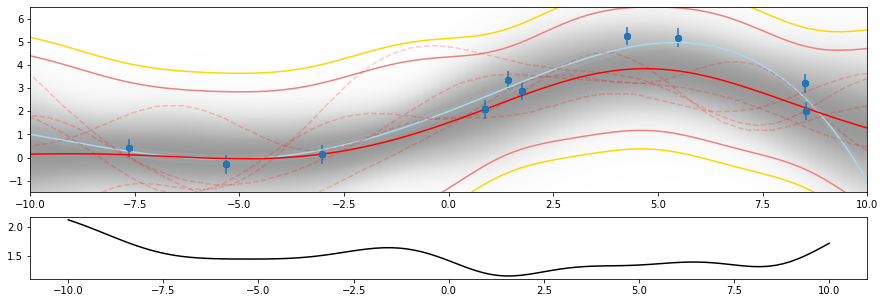

In [25]:
with torch.no_grad():
    output_distribution = model(test_x)
    mpost = output_distribution.mean.unsqueeze(1)
    stdpo = output_distribution.variance.sqrt().unsqueeze(1)
spost = output_distribution.sample(sample_shape=torch.Size([5])).T
plot_prediction(train_x,train_y,test_x,test_y, mpost, spost, stdpo);

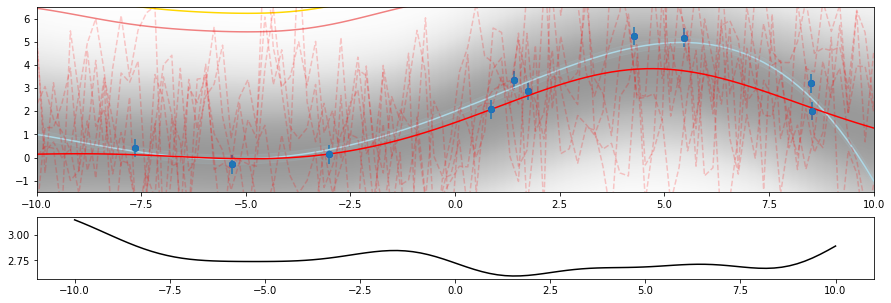

In [26]:
with torch.no_grad():
    output_distribution = likelihood(model(test_x))
    mpost = output_distribution.mean.unsqueeze(1)
    stdpo = output_distribution.variance.sqrt().unsqueeze(1)
spost = output_distribution.sample(sample_shape=torch.Size([5])).T
plot_prediction(train_x,train_y,test_x,test_y, mpost, spost, stdpo);

Issues with the pure PyTorch implementation:
- Numeric unstabilities
- Normalization of training data
- Hyperparameter initializations
- No conjungated gradient

## GPyTorch - Exact GP

https://docs.gpytorch.ai/en/v1.1.1/examples/01_Exact_GPs/Simple_GP_Regression.html  
based on GP book chapter 2: http://www.gaussianprocess.org/gpml/chapters/RW2.pdf

In [27]:
from gpytorch.means import ConstantMean
from gpytorch.kernels import ScaleKernel, RBFKernel
from gpytorch.distributions import MultivariateNormal
from gpytorch.likelihoods import GaussianLikelihood
from gpytorch.models import ExactGP

### Initialize Likelihood

In [28]:
likelihood = GaussianLikelihood()

In [29]:
for name, param in likelihood.named_parameters():
    print(f"likelihood parameter name: {name:32}  param: {param.data}  shape: {param.shape}")

likelihood parameter name: noise_covar.raw_noise             param: tensor([0.])  shape: torch.Size([1])


### Define Model and initialize GP model

In [30]:
# We will use the simplest form of GP model, exact inference
class ExactGPModel(ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = ConstantMean()
        self.covar_module = ScaleKernel(RBFKernel())

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return MultivariateNormal(mean_x, covar_x)

In [31]:
exact_model = ExactGPModel(train_x, train_y, likelihood)

In [32]:
for name, param in exact_model.named_parameters():
    print(f"model parameter name: {name:42} value: {param.data}   shape: {param.shape}")

model parameter name: likelihood.noise_covar.raw_noise           value: tensor([0.])   shape: torch.Size([1])
model parameter name: mean_module.constant                       value: tensor([0.])   shape: torch.Size([1])
model parameter name: covar_module.raw_outputscale               value: 0.0   shape: torch.Size([])
model parameter name: covar_module.base_kernel.raw_lengthscale   value: tensor([[0.]])   shape: torch.Size([1, 1])


Parameter and naming in GP book:  
raw_lengthscale $\equiv$ l  
raw_noise $\equiv$ sigma_y  
mean_module.constant = 0  
raw_outputscale $\equiv$ sigma_f

/home/joerg/miniconda3/lib/python3.8/site-packages/gpytorch/utils/cholesky.py:51: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)


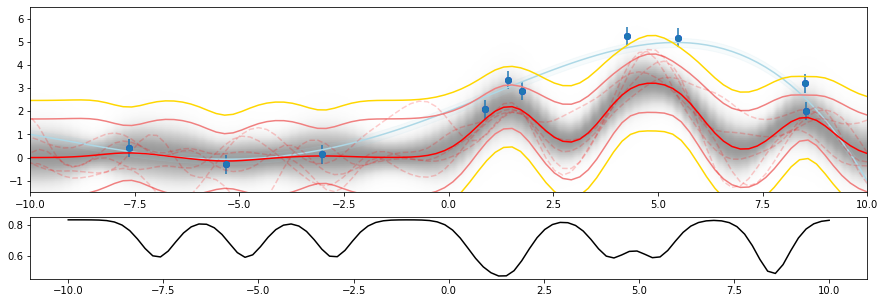

In [33]:
exact_model.eval()
likelihood.eval()
with torch.no_grad():
    output_distribution = exact_model(test_x)
    mpost = output_distribution.mean.unsqueeze(1)
    stdpo = output_distribution.variance.sqrt().unsqueeze(1)
spost = output_distribution.sample(sample_shape=torch.Size([5])).T
plot_prediction(train_x,train_y,test_x,test_y, mpost, spost, stdpo);

### Training in GPyTorch

In [34]:
# Find optimal model hyperparameters
exact_model.train()
likelihood.train()

optimizer = torch.optim.Adam(exact_model.parameters(), lr=0.1)  # Includes GaussianLikelihood parameters

mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, exact_model)

training_iter = 200

for i in tqdm(range(training_iter)):
    optimizer.zero_grad()

    output = exact_model(train_x)
    loss = -mll(output, train_y)
    
    loss.backward()
    if i % 10 == 0:
        print('Iter %d/%d - Loss: %.3f   lengthscale: %.3f   noise: %.3f' % (
            i + 1, training_iter, loss.item(),
            exact_model.covar_module.base_kernel.lengthscale.item(),
            exact_model.likelihood.noise.item()
        ))
    optimizer.step()

  0%|          | 0/200 [00:00<?, ?it/s]

Iter 1/200 - Loss: 3.714   lengthscale: 0.693   noise: 0.693
Iter 11/200 - Loss: 2.134   lengthscale: 1.271   noise: 1.208


 86%|████████▌ | 171/200 [00:00<00:00, 855.55it/s]

Iter 21/200 - Loss: 1.843   lengthscale: 1.881   noise: 1.429
Iter 31/200 - Loss: 1.756   lengthscale: 2.400   noise: 1.300
Iter 41/200 - Loss: 1.688   lengthscale: 2.786   noise: 0.993
Iter 51/200 - Loss: 1.616   lengthscale: 3.056   noise: 0.657
Iter 61/200 - Loss: 1.555   lengthscale: 3.215   noise: 0.400
Iter 71/200 - Loss: 1.530   lengthscale: 3.269   noise: 0.261
Iter 81/200 - Loss: 1.527   lengthscale: 3.266   noise: 0.223
Iter 91/200 - Loss: 1.522   lengthscale: 3.271   noise: 0.240
Iter 101/200 - Loss: 1.519   lengthscale: 3.304   noise: 0.262
Iter 111/200 - Loss: 1.517   lengthscale: 3.347   noise: 0.266
Iter 121/200 - Loss: 1.516   lengthscale: 3.383   noise: 0.257
Iter 131/200 - Loss: 1.515   lengthscale: 3.405   noise: 0.253
Iter 141/200 - Loss: 1.515   lengthscale: 3.420   noise: 0.253
Iter 151/200 - Loss: 1.514   lengthscale: 3.433   noise: 0.255
Iter 161/200 - Loss: 1.514   lengthscale: 3.447   noise: 0.255
Iter 171/200 - Loss: 1.514   lengthscale: 3.459   noise: 0.254


100%|██████████| 200/200 [00:00<00:00, 852.92it/s]


In [35]:
for name, param in exact_model.named_parameters():
    print(f"model parameter name: {name:42} value: {param.data}   shape: {param.shape}")

model parameter name: likelihood.noise_covar.raw_noise           value: tensor([-1.2413])   shape: torch.Size([1])
model parameter name: mean_module.constant                       value: tensor([1.8062])   shape: torch.Size([1])
model parameter name: covar_module.raw_outputscale               value: 3.355463981628418   shape: torch.Size([])
model parameter name: covar_module.base_kernel.raw_lengthscale   value: tensor([[3.4565]])   shape: torch.Size([1, 1])


/home/joerg/miniconda3/lib/python3.8/site-packages/gpytorch/utils/cholesky.py:51: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)


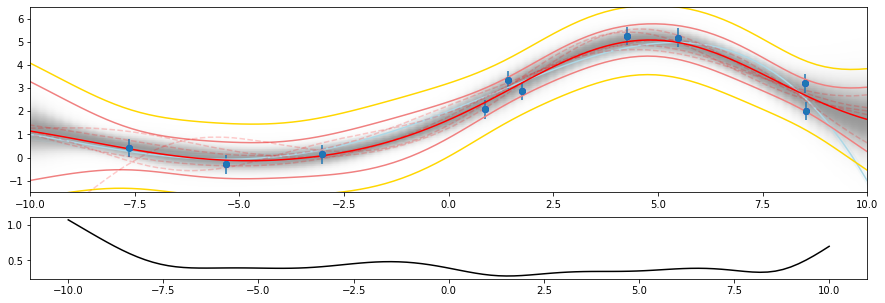

In [36]:
exact_model.eval()
likelihood.eval()
with torch.no_grad():
    output_distribution = exact_model(test_x)
    mpost = output_distribution.mean.unsqueeze(1)
    stdpo = output_distribution.variance.sqrt().unsqueeze(1)
spost = output_distribution.sample(sample_shape=torch.Size([5])).T
plot_prediction(train_x,train_y,test_x,test_y, mpost, spost, stdpo);

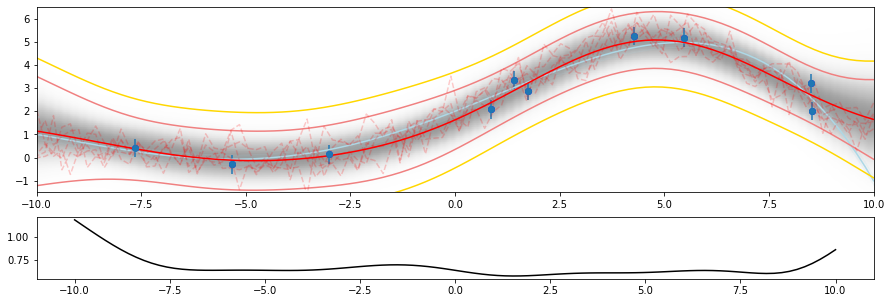

In [37]:
with torch.no_grad():
    output_distribution = likelihood(exact_model(test_x))
    mpost = output_distribution.mean.unsqueeze(1)
    stdpo = output_distribution.variance.sqrt().unsqueeze(1)
spost = output_distribution.sample(sample_shape=torch.Size([5])).T
plot_prediction(train_x,train_y,test_x,test_y, mpost, spost, stdpo);

Issues with Exact GP:
- Does not scale
- No mini-batch training
- Slow inference

## Sparse GPs

https://docs.gpytorch.ai/en/v1.1.1/examples/02_Scalable_Exact_GPs/SGPR_Regression_CUDA.html  
based on 
- **Sparse Gaussian Processes using Pseudo-inputs** https://papers.nips.cc/paper/2005/hash/4491777b1aa8b5b32c2e8666dbe1a495-Abstract.html
- **Variational Learning of Inducing Variables in Sparse Gaussian Processes** http://proceedings.mlr.press/v5/titsias09a/titsias09a.pdf

In [38]:
from gpytorch.kernels import InducingPointKernel

In [39]:
class SparseGPRegressionModel(ExactGP):
    def __init__(self, train_x, train_y, likelihood, inducing_points):
        super().__init__(train_x, train_y, likelihood)
        self.mean_module = ConstantMean()
        self.base_covar_module = ScaleKernel(RBFKernel())
        
        # The novel sparse part:
        self.covar_module = InducingPointKernel(self.base_covar_module, inducing_points=inducing_points, likelihood=likelihood)

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return MultivariateNormal(mean_x, covar_x)

In [40]:
#inducing_points = train_x[:5]*.99
inducing_points = torch.arange(-5, 5, 2.)
inducing_points

tensor([-5., -3., -1.,  1.,  3.])

In [41]:
likelihood = gpytorch.likelihoods.GaussianLikelihood()
sparse_gp_model = SparseGPRegressionModel(train_x.type(torch.FloatTensor), train_y.type(torch.FloatTensor), likelihood, inducing_points)

In [42]:
for name, param in sparse_gp_model.named_parameters():
    print(f"model parameter name: {name:42} shape: {param.shape}  value: {param.data}")

model parameter name: likelihood.noise_covar.raw_noise           shape: torch.Size([1])  value: tensor([0.])
model parameter name: mean_module.constant                       shape: torch.Size([1])  value: tensor([0.])
model parameter name: base_covar_module.raw_outputscale          shape: torch.Size([])  value: 0.0
model parameter name: base_covar_module.base_kernel.raw_lengthscale shape: torch.Size([1, 1])  value: tensor([[0.]])
model parameter name: covar_module.inducing_points               shape: torch.Size([5, 1])  value: tensor([[-5.],
        [-3.],
        [-1.],
        [ 1.],
        [ 3.]])


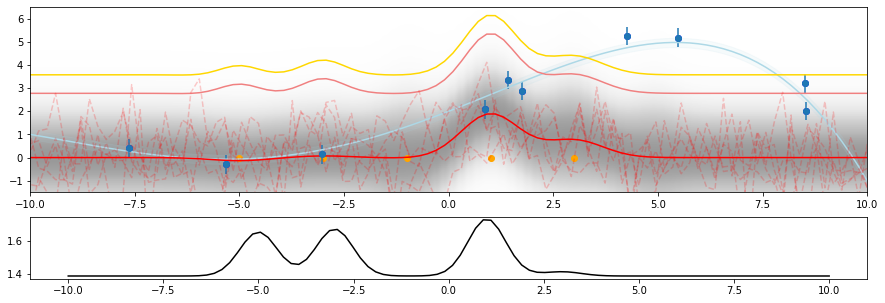

In [43]:
sparse_gp_model.eval()
likelihood.eval()
with torch.no_grad():
    post =  likelihood(sparse_gp_model(test_x))
    mpost = post.mean
    stdpo = post.variance
spost = torch.stack([post.sample() for _ in range(5)], dim=1)
ax = plot_prediction(train_x,train_y,test_x,test_y, mpost, spost, stdpo)

inducing_points = sparse_gp_model.covar_module.inducing_points.data.numpy()
ax[0].scatter(inducing_points, np.zeros_like(inducing_points), c='orange');

In [44]:
# Find optimal model hyperparameters
sparse_gp_model.train()
likelihood.train()

optimizer = torch.optim.Adam(sparse_gp_model.parameters(), lr=0.11) 

mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, sparse_gp_model)

training_iter = 400

for i in tqdm(range(training_iter)):

    optimizer.zero_grad()

    output = sparse_gp_model(train_x)
    loss = -mll(output, train_y)
    
    loss.backward()
    if i % 50 == 0:
        print('Iter %d/%d - Loss: %.3f   lengthscale: %.3f   noise: %.3f' % (
        i + 1, training_iter, loss.item(),
        sparse_gp_model.base_covar_module.base_kernel.raw_lengthscale.item(),
        sparse_gp_model.likelihood.noise.item()
        ))
    optimizer.step()
    torch.cuda.empty_cache()

  9%|▉         | 35/400 [00:00<00:01, 340.43it/s]

Iter 1/400 - Loss: 6.698   lengthscale: 0.000   noise: 0.693
Iter 51/400 - Loss: 1.827   lengthscale: 2.866   noise: 1.726


 39%|███▉      | 157/400 [00:00<00:00, 400.41it/s]

Iter 101/400 - Loss: 1.722   lengthscale: 3.501   noise: 1.206
Iter 151/400 - Loss: 1.614   lengthscale: 3.841   noise: 0.610


 61%|██████▏   | 245/400 [00:00<00:00, 421.48it/s]

Iter 201/400 - Loss: 1.556   lengthscale: 3.932   noise: 0.338
Iter 251/400 - Loss: 1.533   lengthscale: 3.837   noise: 0.287


 94%|█████████▍| 377/400 [00:00<00:00, 432.30it/s]

Iter 301/400 - Loss: 1.524   lengthscale: 3.726   noise: 0.272
Iter 351/400 - Loss: 1.522   lengthscale: 3.686   noise: 0.269


100%|██████████| 400/400 [00:00<00:00, 415.69it/s]


/home/joerg/miniconda3/lib/python3.8/site-packages/gpytorch/distributions/multivariate_normal.py:259: NumericalWarning: Negative variance values detected. This is likely due to numerical instabilities. Rounding negative variances up to 1e-06.
  warnings.warn(
/home/joerg/miniconda3/lib/python3.8/site-packages/gpytorch/lazy/lazy_tensor.py:1362: NumericalWarning: Runtime Error when computing Cholesky decomposition: Matrix not positive definite after repeatedly adding jitter up to 1.0e-04. Original error on first attempt: cholesky_cpu: U(1,1) is zero, singular U.. Using RootDecomposition.
  warnings.warn(


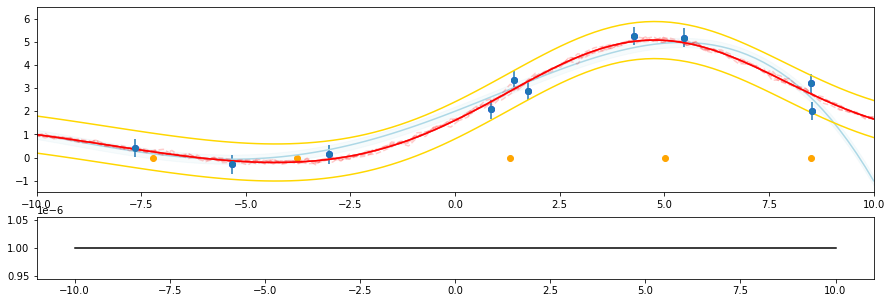

In [45]:
sparse_gp_model.eval()
likelihood.eval()
with torch.no_grad():
    post =  sparse_gp_model(test_x)
mpost = post.mean
stdpo = post.variance
spost = torch.stack([post.sample() for _ in range(5)], dim=1)
ax = plot_prediction(train_x,train_y,test_x,test_y, mpost, spost, stdpo)
inducing_points = sparse_gp_model.covar_module.inducing_points.data.numpy()
ax[0].scatter(inducing_points, np.zeros_like(inducing_points), c='orange');

/home/joerg/miniconda3/lib/python3.8/site-packages/gpytorch/distributions/multivariate_normal.py:259: NumericalWarning: Negative variance values detected. This is likely due to numerical instabilities. Rounding negative variances up to 1e-06.
  warnings.warn(
/home/joerg/miniconda3/lib/python3.8/site-packages/gpytorch/lazy/lazy_tensor.py:1362: NumericalWarning: Runtime Error when computing Cholesky decomposition: Matrix not positive definite after repeatedly adding jitter up to 1.0e-04. Original error on first attempt: cholesky_cpu: U(1,1) is zero, singular U.. Using RootDecomposition.
  warnings.warn(


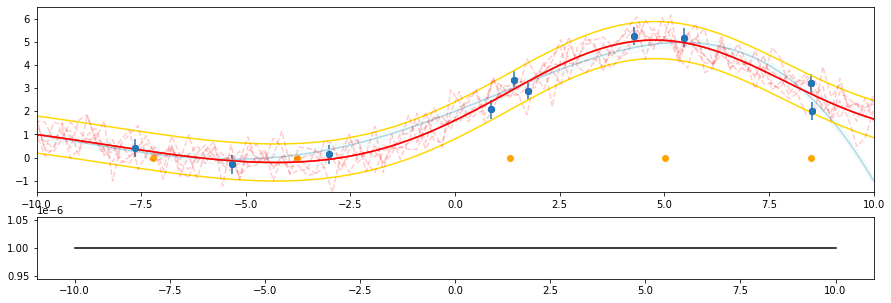

In [46]:
with torch.no_grad():
    post =  likelihood(sparse_gp_model(test_x))
mpost = post.mean
stdpo = post.variance
spost = torch.stack([post.sample() for _ in range(5)], dim=1)
ax = plot_prediction(train_x,train_y,test_x,test_y, mpost, spost, stdpo)
inducing_points = sparse_gp_model.covar_module.inducing_points.data.numpy()
ax[0].scatter(inducing_points, np.zeros_like(inducing_points), c='orange');

Issues with sparse GP:
- Explaines variance in data by Likelihood's $\sigma_{obs}$ (observation noise) and not by model variance $\sigma_f$.
- Overfits to data (maybe due to the parametic carecter of the inducing points) 

## Approximate GPs

https://docs.gpytorch.ai/en/v1.1.1/examples/04_Variational_and_Approximate_GPs/Approximate_GP_Objective_Functions.html   
based on 
- **Sparse Gaussian Processes using Pseudo-inputs** https://papers.nips.cc/paper/2005/hash/4491777b1aa8b5b32c2e8666dbe1a495-Abstract.html
- **Parametric Gaussian Process Regressors** http://proceedings.mlr.press/v119/jankowiak20a.html  
- **Gaussian Processes for Big Data** https://auai.org/uai2013/prints/papers/244.pdf
- **Robust deep gaussian processes** https://arxiv.org/abs/1904.02303
- **Generalized variational inference** https://arxiv.org/abs/1904.02063


In [47]:
from gpytorch.models import ApproximateGP
from gpytorch.variational import CholeskyVariationalDistribution
from gpytorch.variational import VariationalStrategy

In [48]:
class ApproximateGPPModel(ApproximateGP):
    def __init__(self, inducing_points):
        variational_distribution = CholeskyVariationalDistribution(inducing_points.size(0))
        variational_strategy = VariationalStrategy(self, inducing_points, variational_distribution, learn_inducing_locations=True)
        super().__init__( variational_strategy)
        self.mean_module = ConstantMean()
        self.covar_module = ScaleKernel(RBFKernel())

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return MultivariateNormal(mean_x, covar_x)

In [49]:
likelihood = gpytorch.likelihoods.GaussianLikelihood()
approx_gp_model = ApproximateGPPModel(inducing_points=train_x.type(torch.FloatTensor)[:5])

In [50]:
for name, param in approx_gp_model.named_parameters():
    print(f"model parameter name: {name:42} shape: {param.shape}  value: {param.data}")

model parameter name: variational_strategy.inducing_points       shape: torch.Size([5, 1])  value: tensor([[ 8.5345],
        [-7.6468],
        [-5.3205],
        [ 1.4062],
        [ 1.7421]])
model parameter name: variational_strategy._variational_distribution.variational_mean shape: torch.Size([5])  value: tensor([0., 0., 0., 0., 0.])
model parameter name: variational_strategy._variational_distribution.chol_variational_covar shape: torch.Size([5, 5])  value: tensor([[1., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0.],
        [0., 0., 1., 0., 0.],
        [0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 1.]])
model parameter name: mean_module.constant                       shape: torch.Size([1])  value: tensor([0.])
model parameter name: covar_module.raw_outputscale               shape: torch.Size([])  value: 0.0
model parameter name: covar_module.base_kernel.raw_lengthscale   shape: torch.Size([1, 1])  value: tensor([[0.]])


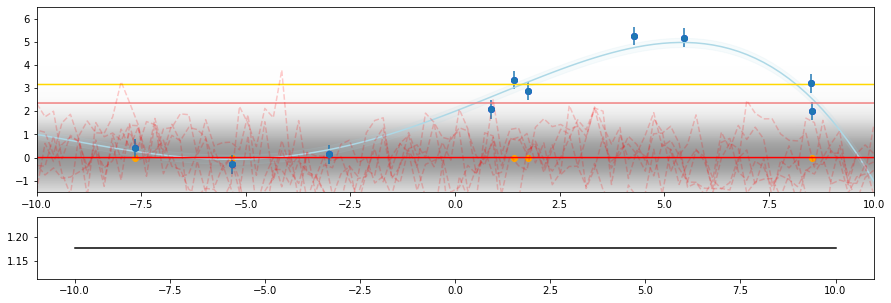

In [51]:
approx_gp_model.eval()
likelihood.eval()
with torch.no_grad():
    output_distribution = likelihood(approx_gp_model(test_x))
mpost = output_distribution.mean.unsqueeze(1)
stdpo = output_distribution.variance.sqrt().unsqueeze(1)
spost = output_distribution.sample(sample_shape=torch.Size([5])).T
ax = plot_prediction(train_x,train_y,test_x,test_y, mpost, spost, stdpo)
inducing_points = approx_gp_model.variational_strategy.inducing_points.data.numpy()
ax[0].scatter(inducing_points, np.zeros_like(inducing_points), c='orange');

In [52]:
# Find optimal model hyperparameters
approx_gp_model.train()
likelihood.train()

optimizer = torch.optim.Adam(approx_gp_model.parameters(), lr=0.001) 

# Our loss object. We're using the VariationalELBO
mll = gpytorch.mlls.VariationalELBO(likelihood, approx_gp_model, num_data=train_y.size(0))

training_iter = 5000

for i in tqdm(range(training_iter)):

    optimizer.zero_grad()
    
    output = approx_gp_model(train_x)
    loss = -mll(output, train_y)
    
    loss.backward()
    if i % 100 == 0:
        print('Iter %d/%d - Loss: %.3f    outputscale: %.3f  lengthscale: %.3f' % (
        i + 1, training_iter, loss.item(),    
        approx_gp_model.covar_module.raw_outputscale.item(),
        approx_gp_model.covar_module.base_kernel.raw_lengthscale.item(),
        ))
    optimizer.step()

  0%|          | 0/5000 [00:00<?, ?it/s]

Iter 1/5000 - Loss: 7.918    outputscale: 0.000  lengthscale: 0.000


  3%|▎         | 146/5000 [00:00<00:13, 360.70it/s]

Iter 101/5000 - Loss: 7.331    outputscale: -0.093  lengthscale: 0.117


  5%|▌         | 256/5000 [00:00<00:13, 352.89it/s]

Iter 201/5000 - Loss: 6.812    outputscale: -0.165  lengthscale: 0.294


  7%|▋         | 366/5000 [00:01<00:12, 361.30it/s]

Iter 301/5000 - Loss: 6.349    outputscale: -0.211  lengthscale: 0.538


  9%|▉         | 440/5000 [00:01<00:12, 362.10it/s]

Iter 401/5000 - Loss: 5.901    outputscale: -0.225  lengthscale: 0.790


 11%|█         | 552/5000 [00:01<00:13, 337.64it/s]

Iter 501/5000 - Loss: 5.426    outputscale: -0.192  lengthscale: 1.022


 13%|█▎        | 657/5000 [00:01<00:13, 331.01it/s]

Iter 601/5000 - Loss: 4.899    outputscale: -0.100  lengthscale: 1.238


 15%|█▌        | 768/5000 [00:02<00:11, 354.07it/s]

Iter 701/5000 - Loss: 4.336    outputscale: 0.046  lengthscale: 1.428


 17%|█▋        | 842/5000 [00:02<00:11, 358.37it/s]

Iter 801/5000 - Loss: 3.803    outputscale: 0.215  lengthscale: 1.587


 19%|█▉        | 952/5000 [00:02<00:11, 356.49it/s]

Iter 901/5000 - Loss: 3.341    outputscale: 0.382  lengthscale: 1.718


 21%|██        | 1062/5000 [00:03<00:11, 339.98it/s]

Iter 1001/5000 - Loss: 2.951    outputscale: 0.538  lengthscale: 1.833


 23%|██▎       | 1171/5000 [00:03<00:11, 345.55it/s]

Iter 1101/5000 - Loss: 2.630    outputscale: 0.681  lengthscale: 1.936


 25%|██▍       | 1245/5000 [00:03<00:10, 356.12it/s]

Iter 1201/5000 - Loss: 2.377    outputscale: 0.809  lengthscale: 2.030


 27%|██▋       | 1356/5000 [00:03<00:10, 363.17it/s]

Iter 1301/5000 - Loss: 2.186    outputscale: 0.923  lengthscale: 2.116


 29%|██▉       | 1467/5000 [00:04<00:09, 364.85it/s]

Iter 1401/5000 - Loss: 2.046    outputscale: 1.022  lengthscale: 2.193


 31%|███       | 1541/5000 [00:04<00:09, 365.48it/s]

Iter 1501/5000 - Loss: 1.947    outputscale: 1.109  lengthscale: 2.262


 33%|███▎      | 1652/5000 [00:04<00:09, 366.89it/s]

Iter 1601/5000 - Loss: 1.878    outputscale: 1.183  lengthscale: 2.323


 35%|███▌      | 1763/5000 [00:04<00:08, 366.54it/s]

Iter 1701/5000 - Loss: 1.832    outputscale: 1.246  lengthscale: 2.378


 37%|███▋      | 1874/5000 [00:05<00:08, 365.54it/s]

Iter 1801/5000 - Loss: 1.800    outputscale: 1.301  lengthscale: 2.428


 39%|███▉      | 1948/5000 [00:05<00:08, 365.85it/s]

Iter 1901/5000 - Loss: 1.778    outputscale: 1.347  lengthscale: 2.473


 41%|████      | 2059/5000 [00:05<00:08, 354.96it/s]

Iter 2001/5000 - Loss: 1.762    outputscale: 1.388  lengthscale: 2.515


 43%|████▎     | 2169/5000 [00:06<00:07, 360.07it/s]

Iter 2101/5000 - Loss: 1.750    outputscale: 1.424  lengthscale: 2.554


 45%|████▍     | 2243/5000 [00:06<00:07, 364.83it/s]

Iter 2201/5000 - Loss: 1.740    outputscale: 1.456  lengthscale: 2.591


 47%|████▋     | 2354/5000 [00:06<00:07, 362.62it/s]

Iter 2301/5000 - Loss: 1.732    outputscale: 1.486  lengthscale: 2.625


 49%|████▉     | 2466/5000 [00:06<00:06, 366.20it/s]

Iter 2401/5000 - Loss: 1.725    outputscale: 1.514  lengthscale: 2.659


 51%|█████     | 2540/5000 [00:07<00:06, 366.92it/s]

Iter 2501/5000 - Loss: 1.718    outputscale: 1.541  lengthscale: 2.692


 53%|█████▎    | 2651/5000 [00:07<00:06, 365.52it/s]

Iter 2601/5000 - Loss: 1.712    outputscale: 1.568  lengthscale: 2.723


 55%|█████▌    | 2762/5000 [00:07<00:06, 364.30it/s]

Iter 2701/5000 - Loss: 1.706    outputscale: 1.594  lengthscale: 2.754


 57%|█████▋    | 2836/5000 [00:07<00:05, 363.43it/s]

Iter 2801/5000 - Loss: 1.700    outputscale: 1.620  lengthscale: 2.785


 59%|█████▉    | 2945/5000 [00:08<00:06, 341.69it/s]

Iter 2901/5000 - Loss: 1.695    outputscale: 1.646  lengthscale: 2.815


 61%|██████    | 3056/5000 [00:08<00:05, 358.51it/s]

Iter 3001/5000 - Loss: 1.689    outputscale: 1.673  lengthscale: 2.844


 63%|██████▎   | 3166/5000 [00:08<00:05, 357.30it/s]

Iter 3101/5000 - Loss: 1.684    outputscale: 1.701  lengthscale: 2.873


 65%|██████▍   | 3240/5000 [00:09<00:04, 362.71it/s]

Iter 3201/5000 - Loss: 1.680    outputscale: 1.728  lengthscale: 2.901


 67%|██████▋   | 3351/5000 [00:09<00:04, 365.51it/s]

Iter 3301/5000 - Loss: 1.675    outputscale: 1.757  lengthscale: 2.929


 69%|██████▉   | 3462/5000 [00:09<00:04, 361.67it/s]

Iter 3401/5000 - Loss: 1.671    outputscale: 1.786  lengthscale: 2.956


 71%|███████▏  | 3573/5000 [00:09<00:03, 363.98it/s]

Iter 3501/5000 - Loss: 1.666    outputscale: 1.816  lengthscale: 2.983


 73%|███████▎  | 3647/5000 [00:10<00:03, 355.42it/s]

Iter 3601/5000 - Loss: 1.662    outputscale: 1.846  lengthscale: 3.009


 75%|███████▌  | 3759/5000 [00:10<00:03, 363.69it/s]

Iter 3701/5000 - Loss: 1.659    outputscale: 1.876  lengthscale: 3.035


 77%|███████▋  | 3833/5000 [00:10<00:03, 362.74it/s]

Iter 3801/5000 - Loss: 1.655    outputscale: 1.907  lengthscale: 3.060


 79%|███████▉  | 3938/5000 [00:11<00:03, 316.99it/s]

Iter 3901/5000 - Loss: 1.652    outputscale: 1.939  lengthscale: 3.084


 81%|████████  | 4033/5000 [00:11<00:03, 304.05it/s]

Iter 4001/5000 - Loss: 1.648    outputscale: 1.971  lengthscale: 3.108


 83%|████████▎ | 4156/5000 [00:11<00:02, 298.21it/s]

Iter 4101/5000 - Loss: 1.645    outputscale: 2.003  lengthscale: 3.131


 85%|████████▍ | 4246/5000 [00:12<00:02, 296.97it/s]

Iter 4201/5000 - Loss: 1.642    outputscale: 2.036  lengthscale: 3.154


 87%|████████▋ | 4336/5000 [00:12<00:02, 296.27it/s]

Iter 4301/5000 - Loss: 1.640    outputscale: 2.068  lengthscale: 3.176


 89%|████████▉ | 4456/5000 [00:12<00:01, 296.84it/s]

Iter 4401/5000 - Loss: 1.637    outputscale: 2.101  lengthscale: 3.197


 91%|█████████ | 4546/5000 [00:13<00:01, 296.95it/s]

Iter 4501/5000 - Loss: 1.635    outputscale: 2.135  lengthscale: 3.217


 93%|█████████▎| 4636/5000 [00:13<00:01, 297.30it/s]

Iter 4601/5000 - Loss: 1.632    outputscale: 2.168  lengthscale: 3.237


 95%|█████████▌| 4756/5000 [00:13<00:00, 297.14it/s]

Iter 4701/5000 - Loss: 1.630    outputscale: 2.201  lengthscale: 3.256


 97%|█████████▋| 4860/5000 [00:14<00:00, 330.70it/s]

Iter 4801/5000 - Loss: 1.628    outputscale: 2.234  lengthscale: 3.275


 99%|█████████▉| 4966/5000 [00:14<00:00, 344.14it/s]

Iter 4901/5000 - Loss: 1.626    outputscale: 2.268  lengthscale: 3.292


100%|██████████| 5000/5000 [00:14<00:00, 344.41it/s]


In [53]:
for name, param in approx_gp_model.named_parameters():
    print(f"model parameter name: {name:42} shape: {param.shape}  value: {param.data}")

model parameter name: variational_strategy.inducing_points       shape: torch.Size([5, 1])  value: tensor([[ 8.2424],
        [-7.2027],
        [-3.8730],
        [ 1.1819],
        [ 4.7077]])
model parameter name: variational_strategy._variational_distribution.variational_mean shape: torch.Size([5])  value: tensor([ 0.9578, -0.7481, -0.5745,  1.0136,  1.6465])
model parameter name: variational_strategy._variational_distribution.chol_variational_covar shape: torch.Size([5, 5])  value: tensor([[ 0.3316,  0.0000,  0.0000,  0.0000,  0.0000],
        [-0.0019,  0.4002,  0.0000,  0.0000,  0.0000],
        [ 0.0069, -0.2225,  0.4722,  0.0000,  0.0000],
        [-0.0556,  0.0612, -0.1681,  0.3141,  0.0000],
        [-0.1590, -0.0307,  0.0933, -0.2128,  0.5324]])
model parameter name: mean_module.constant                       shape: torch.Size([1])  value: tensor([1.4727])
model parameter name: covar_module.raw_outputscale               shape: torch.Size([])  value: 2.301016092300415
model 

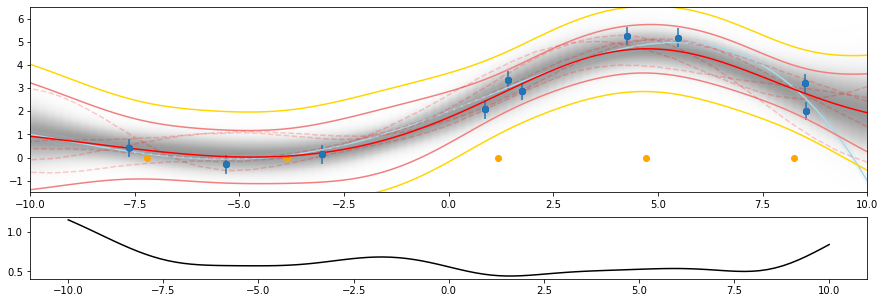

In [54]:
with torch.no_grad():
    output_distribution = approx_gp_model(test_x)
mpost = output_distribution.mean.unsqueeze(1)
stdpo = output_distribution.variance.sqrt().unsqueeze(1)
spost = output_distribution.sample(sample_shape=torch.Size([5])).T
ax = plot_prediction(train_x,train_y,test_x,test_y, mpost, spost, stdpo)

inducing_points = approx_gp_model.variational_strategy.inducing_points.data.numpy()
ax[0].scatter(inducing_points, np.zeros_like(inducing_points), c='orange');

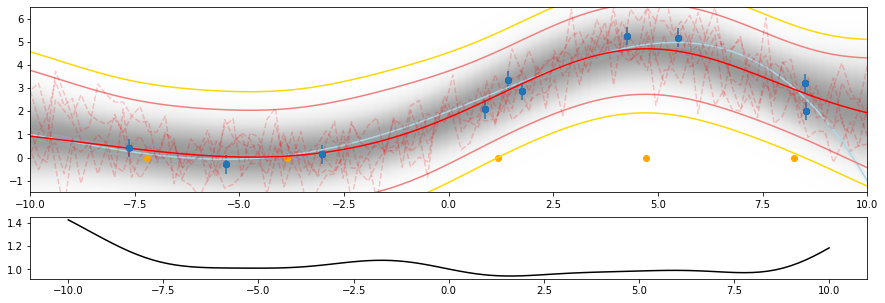

In [55]:
approx_gp_model.eval()
likelihood.eval()
with torch.no_grad():
    output_distribution = likelihood(approx_gp_model(test_x))
mpost = output_distribution.mean.unsqueeze(1)
stdpo = output_distribution.variance.sqrt().unsqueeze(1)
spost = output_distribution.sample(sample_shape=torch.Size([5])).T
ax = plot_prediction(train_x,train_y,test_x,test_y, mpost, spost, stdpo)

inducing_points = approx_gp_model.variational_strategy.inducing_points.data.numpy()
ax[0].scatter(inducing_points, np.zeros_like(inducing_points), c='orange');